In [1]:
%pylab inline
from pyspark.sql.types import *
from datetime import datetime
from pyspark.sql import Row
from time import time

Populating the interactive namespace from numpy and matplotlib


In [2]:
fields = [StructField("archived", BooleanType(), True),
        StructField("author", StringType(), True),
        StructField("author_flair_css_class", StringType(), True),
        StructField("body", StringType(), True),
        StructField("controversiality", LongType(), True),
        StructField("created_utc", StringType(), True),
        StructField("day", LongType(), True),
        StructField("distinguished", StringType(), True),
        StructField("downs", LongType(), True),
        StructField("edited", StringType(), True),
        StructField("gilded", LongType(), True),
        StructField("id", StringType(), True),
        StructField("link_id", StringType(), True),
        StructField("month", LongType(), True),
        StructField("name", StringType(), True),
        StructField("parent_id", StringType(), True),
        StructField("retrieved_on", LongType(), True),
        StructField("score", LongType(), True),
        StructField("score_hidden", BooleanType(), True),
        StructField("subreddit", StringType(), True),
        StructField("subreddit_id", StringType(), True),
        StructField("ups", LongType(), True),
        StructField("year", LongType(), True)]
rawDF = sqlContext.read.json("s3n://reddit-comments/2008", StructType(fields))
rawDF.persist(StorageLevel.MEMORY_AND_DISK_SER)
rawDF.count()

7242871

In [3]:
# Setting up DataFrames to have various number of partitions ranging from 1 to 32
# All will be persisted in memory and the same job will be run on each one to show performance benefits
repart_1_df = rawDF.repartition(1).persist(StorageLevel.MEMORY_AND_DISK_SER)
repart_2_df = rawDF.repartition(2).persist(StorageLevel.MEMORY_AND_DISK_SER)
repart_4_df = rawDF.repartition(4).persist(StorageLevel.MEMORY_AND_DISK_SER)
repart_8_df = rawDF.repartition(8).persist(StorageLevel.MEMORY_AND_DISK_SER)
repart_16_df = rawDF.repartition(16).persist(StorageLevel.MEMORY_AND_DISK_SER)
repart_32_df = rawDF.repartition(32).persist(StorageLevel.MEMORY_AND_DISK_SER)

repart_1_df.registerTempTable("repart_1")
repart_2_df.registerTempTable("repart_2")
repart_4_df.registerTempTable("repart_4")
repart_8_df.registerTempTable("repart_8")
repart_16_df.registerTempTable("repart_16")
repart_32_df.registerTempTable("repart_32")

In [4]:
# Run through each DataFrame and count the number of elements in each. This will 
# trigger the DataFrames to persist into Memory and Disk
df_arr = [(repart_1_df, 1), 
          (repart_2_df, 2), 
          (repart_4_df, 4), 
          (repart_8_df, 8), 
          (repart_16_df, 16), 
          (repart_32_df, 32)]
for df in df_arr:
    start_time = time()
    df[0].count()
    end_time = time()
    print "{} partitions took {} seconds to repartition and count".format(df[1], end_time - start_time) 

1 partitions took 199.992575884 seconds to repartition and count
2 partitions took 103.900455952 seconds to repartition and count
4 partitions took 57.8256669044 seconds to repartition and count
8 partitions took 45.2975502014 seconds to repartition and count
16 partitions took 31.8315329552 seconds to repartition and count
32 partitions took 33.4327778816 seconds to repartition and count


In [11]:
# Function sorts an array of UTC time and calculates the delta time in days between each consecutive UTC time
# Returns a Row object containing the subreddit, the median time delta representing the median time in days 
# between comments for any subreddit, and the total number of comments in each subreddit
def calc_median(row):
    subreddit = row[0]
    val_arr = row[1]
    sorted_arr = sorted(val_arr)
    dt = []
    if len(sorted_arr)>0:
        for i in range(len(sorted_arr)-1):
            dt.append(int(sorted_arr[i+1])-int(sorted_arr[i]))
    else:
        dt = [0]
        
    return Row(subreddit=subreddit, median_time_days=float(median(dt)/60/60/24), num_comments=len(sorted_arr))

In [ ]:
# Loop through each DataFrame and run the same job to calculate the median time between comments for each
# subreddit
for df in df_arr:
    start_time = time()
    curr_df = df[0]
    num_partitions = df[1]
    
    subreddit_comment_times = curr_df.rdd.map(lambda r: (r.subreddit, r.created_utc))
    median_time_between_posts_df = subreddit_comment_times.groupByKey()\
                                                          .map(calc_median)\
                                                          .toDF()
    total_cnt = median_time_between_posts_df.count()
    end_time = time()
    print "{} partitions took {} seconds to process, {} final records".format(df[1], end_time - start_time, total_cnt) 

1 partitions took 201.440960884 seconds to process, 2695 records
2 partitions took 109.790168047 seconds to process, 2695 records

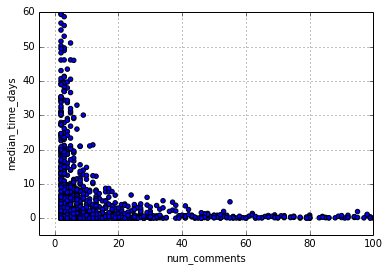

In [7]:
# A scatter plot where each element is a subreddit. We can see that subreddits with more than 40 comments tend to
# also have more frequent comment activity throughout the year
median_time_between_posts_pd = median_time_between_posts_df.toPandas()
median_time_between_posts_pd.plot(kind='scatter', x='num_comments', y='median_time_days', xlim=(-5, 100), ylim=(-5, 60))